# Working with tables

## Titanic dataset download and overview

In [1]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers.experimental import preprocessing

In [2]:
pd.set_option('max_rows', 10000)

### Overview

In [3]:
TRAIN_DATA_URL = "https://storage.googleapis.com/tf-datasets/titanic/train.csv"
TEST_DATA_URL = "https://storage.googleapis.com/tf-datasets/titanic/eval.csv"

train_file_path = tf.keras.utils.get_file("train.csv", TRAIN_DATA_URL)
test_file_path = tf.keras.utils.get_file("eval.csv", TEST_DATA_URL)

24576/13049 [========================================================] - 0s 0us/step


In [4]:
!head {train_file_path}

survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.25,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
1,female,26.0,0,0,7.925,Third,unknown,Southampton,y
1,female,35.0,1,0,53.1,First,C,Southampton,n
0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y
0,male,2.0,3,1,21.075,Third,unknown,Southampton,n
1,female,27.0,0,2,11.1333,Third,unknown,Southampton,n
1,female,14.0,1,0,30.0708,Second,unknown,Cherbourg,n
1,female,4.0,1,1,16.7,Third,G,Southampton,n


About the dataset
- Each row corresponds to a passenger.
- Contains attributes for each passenger - their age, gender, the class they travelled on, how much they paid for their fares, which deck they are on (A-G), which town they got onto the Titanic

## Data preparation and exploratory analysis


### Split the dataframe into train, validation and test

In [5]:
train = pd.read_csv(train_file_path)
test = pd.read_csv(test_file_path)

In [6]:
test, val = train_test_split(test, test_size=0.5)

In [7]:
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

627 train examples
132 validation examples
132 test examples


### Exploratory analysis

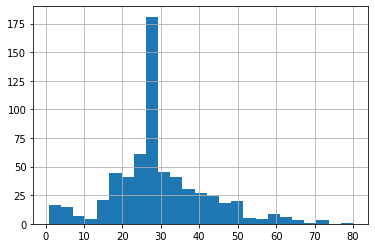

In [8]:
train.age.hist(bins=25)

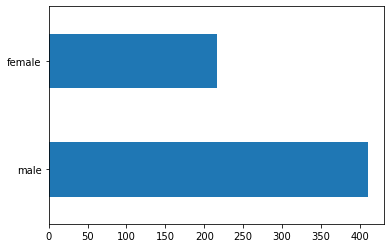

In [9]:
train.sex.value_counts().plot(kind='barh')

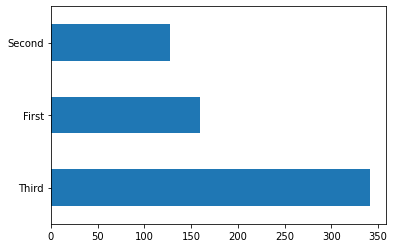

In [10]:
train['class'].value_counts().plot(kind='barh')

Text(0.5, 0, '% survived')

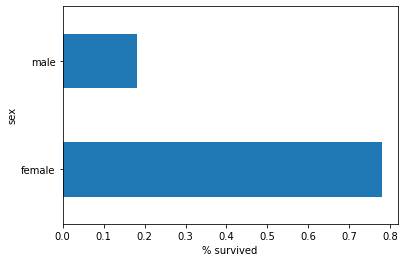

In [11]:
train.groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survived')

In [12]:
#Q - Why do we need the columns field - we already have n_siblings_spouses
train[train.n_siblings_spouses == 0].alone.value_counts()
#So 50 are no siblings, spouses - travelling with parents, children or friends

y    372
n     50
Name: alone, dtype: int64

In [13]:
train[(train.n_siblings_spouses == 0) & (train.parch == 0)].alone.value_counts()
# So no one travelled just with friends

y    372
Name: alone, dtype: int64

In [14]:
train[(train.age < 18) & (train['class'] == 'First')]

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
221,1,female,17.0,1,0,108.9000,First,C,Cherbourg,n
315,1,female,14.0,1,2,120.0000,First,B,Southampton,n
395,1,male,17.0,0,2,110.8833,First,C,Cherbourg,n
489,1,female,15.0,0,1,211.3375,First,B,Southampton,n
547,1,female,17.0,1,0,57.0000,First,B,Southampton,n
565,1,male,11.0,1,2,120.0000,First,B,Southampton,n
601,1,female,16.0,0,1,39.4000,First,D,Southampton,n


- Observation that if you were a child and in first class that you survived

## Big picture
Compare with Fashion MNIST

### Model architecture
Fashion MNIST

![Fashion MNIST](https://drive.google.com/uc?id=1agv0HpjsUfb1E4Hgcs_rIldhcV90NiOK)

### model build

In [15]:
# FashionMNIST
#model = tf.keras.Sequential([
#  tf.keras.layers.Flatten(input_shape=(28, 28)),                           
#  tf.keras.layers.Dense(128, activation='relu'), 
#  tf.keras.layers.Dense(64, activation='relu'),                              
#  tf.keras.layers.Dense(10),                             
#  ])

In [16]:
# Titanic
#all_features = tf.keras.layers.concatenate(encoded_features)
#x = tf.keras.layers.Dense(128, activation="relu")(all_features)
#x = tf.keras.layers.Dense(64, activation="relu")(all_features)
#x = tf.keras.layers.Dropout(0.1)(x)
#output = tf.keras.layers.Dense(1)(x)

#model = tf.keras.Model(all_inputs, output)

### model - compile

In [17]:
# FashionMNIST
#model.compile(optimizer='adam',
#              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#              metrics=['accuracy'])

In [18]:
# Titanic
#model.compile(optimizer='adam',
#              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#              metrics=["accuracy"])

### Model - fit

In [19]:
# FashionMNIST
#model.fit(train_images, train_labels, epochs=10, batch_size=64, validation_split=0.1)

In [20]:
# Titanic
#model.fit(train_ds, validation_data=val_ds, epochs=10)

## Create an input pipeline using tf.data



Next, you will wrap the dataframes with [tf.data](https://www.tensorflow.org/guide/datasets), in order to shuffle and batch the data. If you were working with a very large CSV file (so large that it does not fit into memory), you would use tf.data to read it from disk directly. 
- the Data API uses the concept of a dataset which represents a sequence of data items
- Usually we use datasets to gradually read data from disk but we can create a dataset entirely in RAM using tf.data.Dataset.from_tensor_slices()
- Let's take a look at from_tensor_slices to see what the arguments are and what is returned

The [TensorFlow 2.0 Documentation](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) has more information about tf.data.Dataset and tf.data.Dataset.from_tensor_slices

In [21]:
help(tf.data.Dataset.from_tensor_slices)

Help on function from_tensor_slices in module tensorflow.python.data.ops.dataset_ops:

from_tensor_slices(tensors)
    Creates a `Dataset` whose elements are slices of the given tensors.
    
    The given tensors are sliced along their first dimension. This operation
    preserves the structure of the input tensors, removing the first dimension
    of each tensor and using it as the dataset dimension. All input tensors
    must have the same size in their first dimensions.
    
    >>> # Slicing a 1D tensor produces scalar tensor elements.
    >>> dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])
    >>> list(dataset.as_numpy_iterator())
    [1, 2, 3]
    
    >>> # Slicing a 2D tensor produces 1D tensor elements.
    >>> dataset = tf.data.Dataset.from_tensor_slices([[1, 2], [3, 4]])
    >>> list(dataset.as_numpy_iterator())
    [array([1, 2], dtype=int32), array([3, 4], dtype=int32)]
    
    >>> # Slicing a tuple of 1D tensors produces tuple elements containing
    >>> # scala

- 

In [22]:
# Let's first make a copy of the dataframe
dataframe = train.copy()
# Now we want is to include the training data and the labelled data. 
# Since from_tensor_slices only accepts one argument, we'll use a tuple.
# So the first element is the training data and the 2nd element is the label.
# From the documentation, you can see that we can't use a dataframe directly, but can use dictionaries.
# Let's convert the dataframe into a dictionary  
ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), dataframe.pop('survived')))
for item in ds:
  print(item)


({'survived': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'sex': <tf.Tensor: shape=(), dtype=string, numpy=b'male'>, 'age': <tf.Tensor: shape=(), dtype=float64, numpy=22.0>, 'n_siblings_spouses': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'parch': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'fare': <tf.Tensor: shape=(), dtype=float64, numpy=7.25>, 'class': <tf.Tensor: shape=(), dtype=string, numpy=b'Third'>, 'deck': <tf.Tensor: shape=(), dtype=string, numpy=b'unknown'>, 'embark_town': <tf.Tensor: shape=(), dtype=string, numpy=b'Southampton'>, 'alone': <tf.Tensor: shape=(), dtype=string, numpy=b'n'>}, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
({'survived': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'sex': <tf.Tensor: shape=(), dtype=string, numpy=b'female'>, 'age': <tf.Tensor: shape=(), dtype=float64, numpy=38.0>, 'n_siblings_spouses': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'parch': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'fare': <tf.Tensor: shape=(), dtype=float64, 

- Let's take everything we have learned and put it into a function
- We'll also want the option of being able to shuffle the dataset
- Datasets also have methods for batching and prefetching that we will add to our function.

In [23]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=3):
  dataframe = dataframe.copy()
  labels = dataframe.pop('survived')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  #We'll also want to process this a batch-size at a time, so we can use the batch method.  
  ds = ds.batch(batch_size)
  #Datasets also give us the option to improve performance using methods like prefetch.
  # While our training algorithm is working on one batch, typically on a GPU
  # The dataset will be working in parallel on getting the next batch ready
  # This means the GPUs are more effectively utilised and so the training will run faster. 
  ds = ds.prefetch(batch_size)
  return ds

Now that you have created the input pipeline, let's call it to see the format of the data it returns. We have used a small batch size to keep the output readable.

In [24]:
train_ds = df_to_dataset(train)
train_ds

<PrefetchDataset shapes: ({sex: (None,), age: (None,), n_siblings_spouses: (None,), parch: (None,), fare: (None,), class: (None,), deck: (None,), embark_town: (None,), alone: (None,)}, (None,)), types: ({sex: tf.string, age: tf.float64, n_siblings_spouses: tf.int64, parch: tf.int64, fare: tf.float64, class: tf.string, deck: tf.string, embark_town: tf.string, alone: tf.string}, tf.int64)>

In [25]:
[(train_features, label_batch)] = train_ds.take(1)
label_batch

<tf.Tensor: shape=(3,), dtype=int64, numpy=array([0, 0, 1])>

In [26]:
[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of ages:', train_features['age'])
print('A batch of labels:', label_batch )

Every feature: ['sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck', 'embark_town', 'alone']
A batch of ages: tf.Tensor([40. 24. 45.], shape=(3,), dtype=float64)
A batch of labels: tf.Tensor([1 1 1], shape=(3,), dtype=int64)


## Feature engineering

### Numeric columns
- There are a couple of numeric columns: age, fare, n_siblings_spouses, parch
- In general machine learning algorithms don't perform well when the input numerical attributes have different scales. 
- let's take a look at the range of values using describe

In [27]:
train.describe()
# You can see that the min values for most of the numeric fields are close to 0.
# The maximum values vary a fair bit where we have 512 for the fair paid but maximum number for the number of siblings and spouses is only 8. 
# That's quite a big difference which is why we apply normalization.

,survived,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000,627.000000
mean,0.387560,29.631308,0.545455,0.379585,34.385399
std,0.487582,12.511818,1.151090,0.792999,54.597730
min,0.000000,0.750000,0.000000,0.000000,0.000000
25%,0.000000,23.000000,0.000000,0.000000,7.895800
50%,0.000000,28.000000,0.000000,0.000000,15.045800
75%,1.000000,35.000000,1.000000,0.000000,31.387500
max,1.000000,80.000000,8.000000,5.000000,512.329200


- You can see that the For each of the Numeric feature, you will use a Normalization() layer to make sure the mean of each feature is 0 and its standard deviation is 1.

`get_normalization_layer` function returns a layer which applies featurewise normalization to numerical features.

In [28]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for our feature.
  normalizer = preprocessing.Normalization(axis=None)

  # Prepare a Dataset that only yields our feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # What we will return here is a layer with features normalized.
  # This is a non-trainable layer, so we don't set its state during training but before training in a step called adaptation.
  # We set the state of the proprocessing layer using the adapt() method - pointing to this adaptation step.
  normalizer.adapt(feature_ds)

  return normalizer

[The TensorFlow 2.0 Documentation](https://www.tensorflow.org/guide/keras/preprocessing_layers#the_adapt_method) has more information on the adapt method

In [29]:
age_column = train_features['age']
age_column

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([40., 24., 45.])>

In [30]:
numeric_layer = get_normalization_layer('age', train_ds)
numeric_layer(age_column)

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([ 0.82937306, -0.4504389 ,  1.2293143 ], dtype=float32)>

Note: If you many numeric features (hundreds, or more), it is more efficient to concatenate them first and use a single [normalization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Normalization) layer.

### Categorical columns


In this dataset, the town that passengers embarked is represented as a string (e.g. 'Southampton', 'Cherbourg', 'Queenstown' or 'unknown'). You cannot feed strings directly to a model. The preprocessing layer takes care of representing strings as a one-hot vector.

In [31]:
train.embark_town.unique()

array(['Southampton', 'Cherbourg', 'Queenstown', 'unknown'], dtype=object)

`get_category_encoding_layer` function returns a layer which maps values from a vocabulary to integer indices and one-hot encodes the features.

In [32]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a StringLookup layer which will turn strings into integer indices
  if dtype == 'string':
    index = preprocessing.StringLookup(max_tokens=max_tokens)
  else:
    index = preprocessing.IntegerLookup(max_tokens=max_tokens)

  # Prepare a Dataset that only yields our feature
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Create a Discretization for our integer indices.
  encoder = preprocessing.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply one-hot encoding to our indices. The lambda function captures the
  # layer so we can use them, or include them in the functional model later.
  return lambda feature: encoder(index(feature))

The TensorFlow 2.0 Documentation has more details on [StringLookup](https://www.tensorflow.org/api_docs/python/tf/keras/layers/StringLookup), [IntegerLookup](https://www.tensorflow.org/api_docs/python/tf/keras/layers/IntegerLookup) and [CategoryEncoding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/CategoryEncoding)

In [33]:
index = preprocessing.StringLookup(max_tokens=None)
feature_ds = train_ds.map(lambda x, y: x['embark_town'])
index.adapt(feature_ds)
# What do we mean by vocabulary? It's the unique values for that column. 
print(f'vocabulary: {index.get_vocabulary()}')
print(f'vocabulary size: {index.vocabulary_size()}')

vocabulary: ['[UNK]', 'Southampton', 'Cherbourg', 'Queenstown', 'unknown']
vocabulary size: 5


You are probably wondering what the [UNK] token is because that isn't one of our embark_towns.
Tensorflow automatically adds this as a placeholder for any out of vocabulary values

In [34]:
index.oov_token

'[UNK]'

We could change the column so we are looking at the sex instead
feature_ds = train_ds.map(lambda x, y: x['sex'])
And we would get all of the unique values for that column and the UNK token 

In [35]:
embark_town_column = train_features['embark_town']
embark_town_column

<tf.Tensor: shape=(3,), dtype=string, numpy=array([b'Cherbourg', b'Southampton', b'Southampton'], dtype=object)>

In [36]:
categorical_layer = get_category_encoding_layer('embark_town', train_ds, 'string')
categorical_layer(embark_town_column)

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 1., 1., 0., 0.], dtype=float32)>

### Creating a pipeline

In [37]:
batch_size = 64
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [38]:
all_inputs = []
encoded_features = []

# Numeric features.
numeric_columns = ['age', 'n_siblings_spouses', 'parch', 'fare']
for column_name in numeric_columns:
  numeric_column = tf.keras.Input(shape=(1,), name=column_name)
  normalization_layer = get_normalization_layer(column_name, train_ds)
  encoded_numeric_column = normalization_layer(numeric_column)
  all_inputs.append(numeric_column)
  encoded_features.append(encoded_numeric_column)

# Categorical features encoded as string.
categorical_columns = ['sex', 'class', 'embark_town', 'deck', 'alone']
for column_name in categorical_columns:
  categorical_column = tf.keras.Input(shape=(1,), name=column_name, dtype='string')
  encoding_layer = get_category_encoding_layer(column_name, train_ds, dtype='string', max_tokens=5)
  encoded_categorical_column = encoding_layer(categorical_column)
  all_inputs.append(categorical_column)
  encoded_features.append(encoded_categorical_column)

Let's take a look at the list all_inputs to see what we have. You can see these are the different columns

In [39]:
all_inputs

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'age')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'n_siblings_spouses')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'parch')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'fare')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'sex')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'class')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'embark_town')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'deck')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'alone')>]

The encoded_features is all of the layers that have been normalized for numeric values and have category encoding for categorical values

In [40]:
encoded_features

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_1')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_2')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_3')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_4')>,
 <KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'category_encoding_1')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'category_encoding_2')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'category_encoding_3')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'category_encoding_4')>,
 <KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'category_encoding_5')>]

## Create, compile and train the model

### Create and compile model

In [41]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(128, activation="relu")(all_features)
x = tf.keras.layers.Dense(64, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.1)(x)
output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(all_inputs, output)

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

Fashion MNIST neural network model
![Fashion MNIST](https://drive.google.com/uc?id=1agv0HpjsUfb1E4Hgcs_rIldhcV90NiOK)

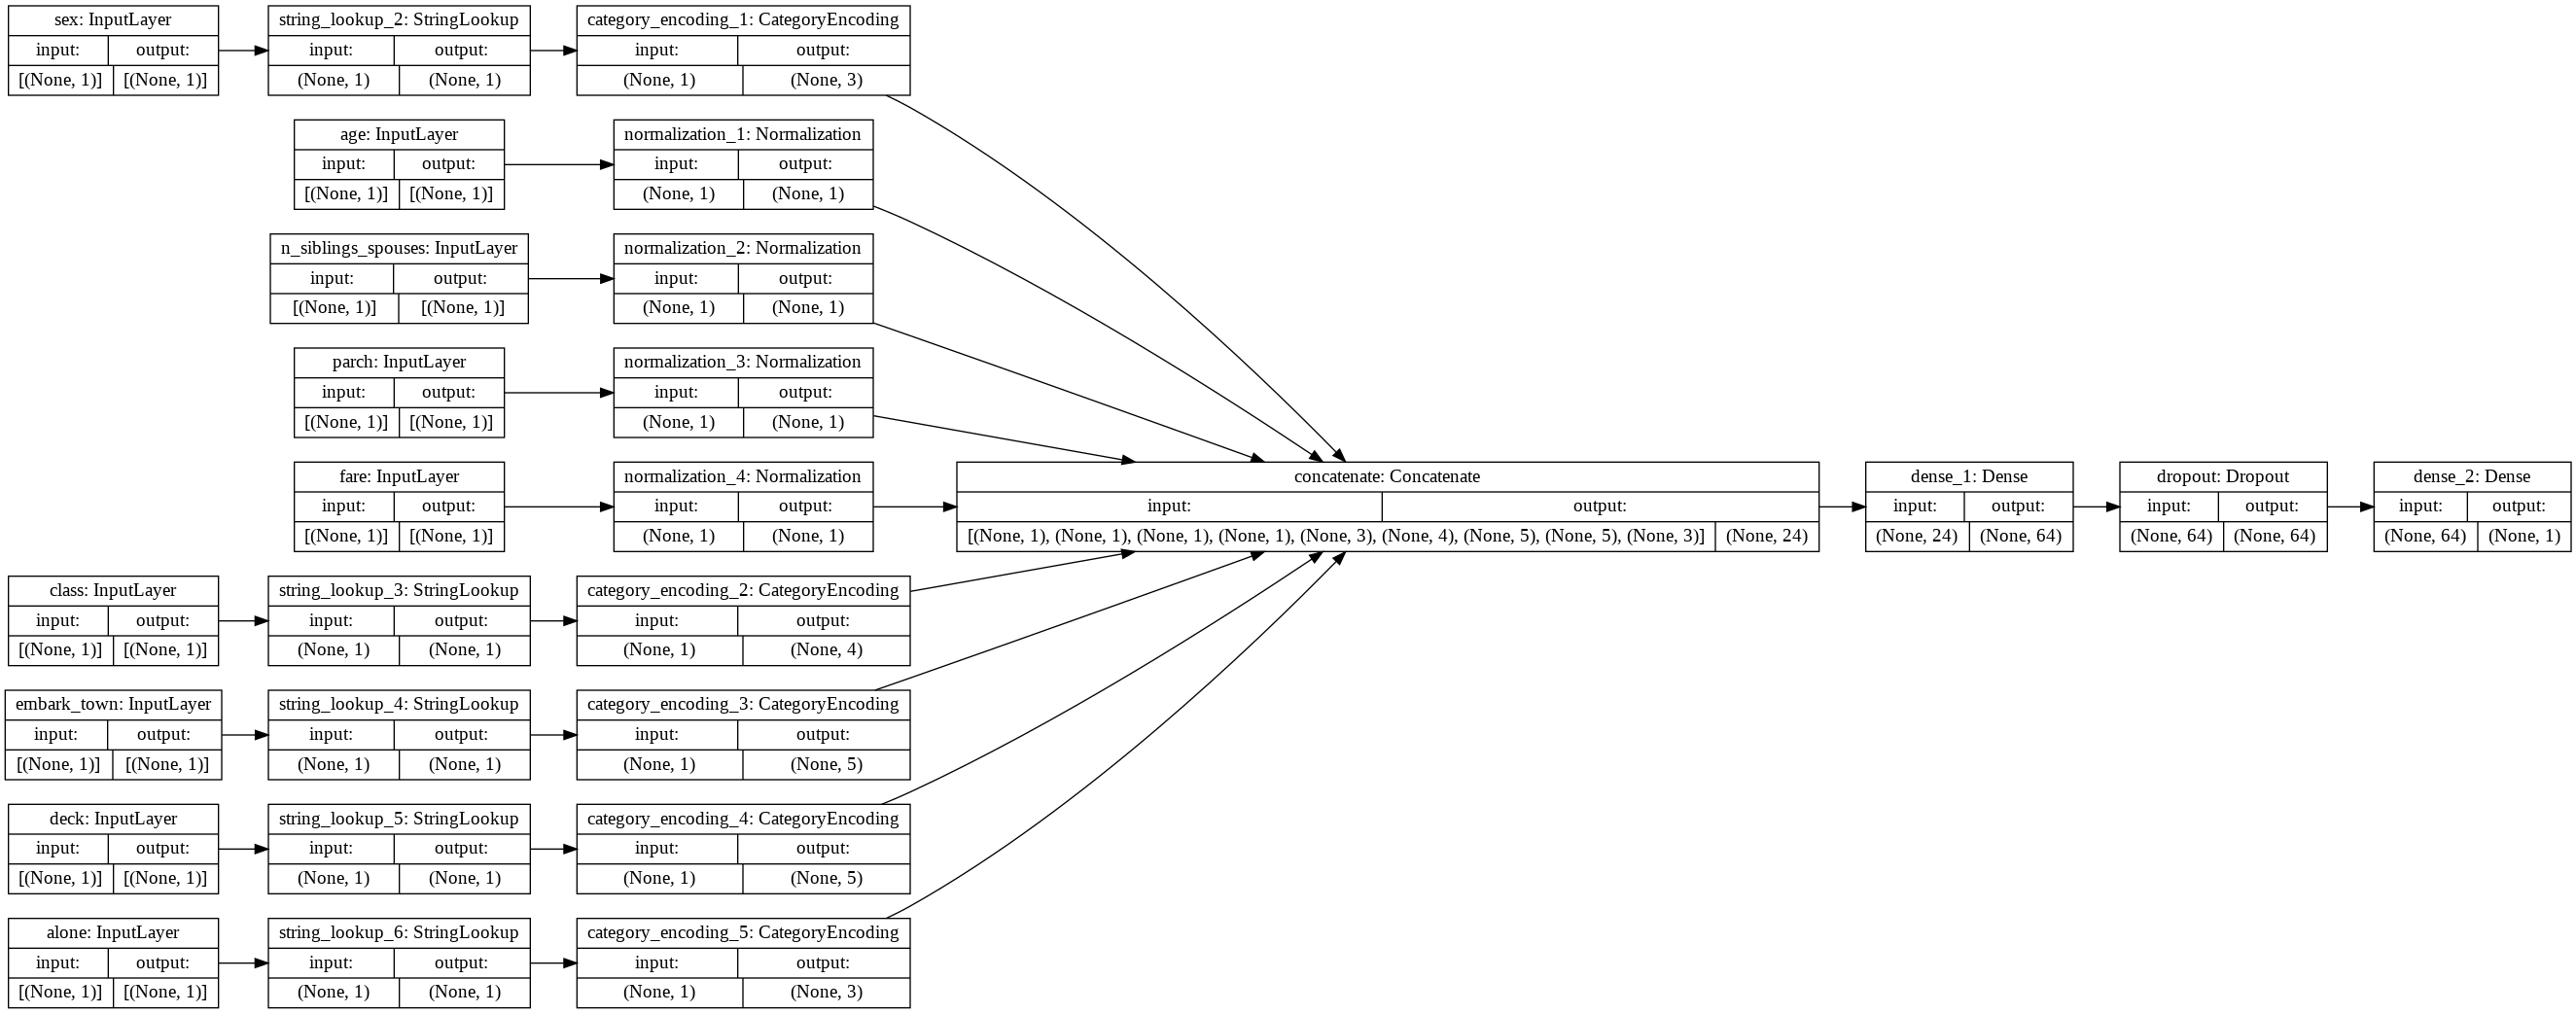

In [42]:
# rankdir='LR' is used to make the graph horizontal.
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

### Train and evaluate model

In [43]:
model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
10/10 [==============================] - 1s 39ms/step - loss: 0.6661 - accuracy: 0.6172 - val_loss: 0.6266 - val_accuracy: 0.6061
Epoch 2/10
10/10 [==============================] - 0s 6ms/step - loss: 0.6146 - accuracy: 0.6188 - val_loss: 0.5863 - val_accuracy: 0.6061
Epoch 3/10
10/10 [==============================] - 0s 6ms/step - loss: 0.5732 - accuracy: 0.6252 - val_loss: 0.5531 - val_accuracy: 0.6212
Epoch 4/10
10/10 [==============================] - 0s 5ms/step - loss: 0.5452 - accuracy: 0.6427 - val_loss: 0.5271 - val_accuracy: 0.6591
Epoch 5/10
10/10 [==============================] - 0s 4ms/step - loss: 0.5214 - accuracy: 0.6810 - val_loss: 0.5063 - val_accuracy: 0.7045
Epoch 6/10
10/10 [==============================] - 0s 4ms/step - loss: 0.4979 - accuracy: 0.7065 - val_loss: 0.4890 - val_accuracy: 0.7197
Epoch 7/10
10/10 [==============================] - 0s 4ms/step - loss: 0.4809 - accuracy: 0.7416 - val_loss: 0.4743 - val_accuracy: 0.7273
Epoch 8/10
10/10 [=

In [44]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

3/3 [==============================] - 0s 4ms/step - loss: 0.5048 - accuracy: 0.7652
Accuracy 0.7651515007019043


### Inference on new data

In [45]:
model.save('classifier')
titanic_model = tf.keras.models.load_model('classifier')

INFO:tensorflow:Assets written to: classifier/assets


In [46]:
train[(train.age < 18) & (train['class'] == 'First')]

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
221,1,female,17.0,1,0,108.9000,First,C,Cherbourg,n
315,1,female,14.0,1,2,120.0000,First,B,Southampton,n
395,1,male,17.0,0,2,110.8833,First,C,Cherbourg,n
489,1,female,15.0,0,1,211.3375,First,B,Southampton,n
547,1,female,17.0,1,0,57.0000,First,B,Southampton,n
565,1,male,11.0,1,2,120.0000,First,B,Southampton,n
601,1,female,16.0,0,1,39.4000,First,D,Southampton,n


This seems to indicate that if you were a child (< 18) and in First class, you survived. Let's see if our model predicts someone like this survives if:
1. You are female and less than 18, travelling on First class
2. You are travelling alone (no examples of this in the training dataset)

In [47]:
train.loc[0, :]
sample = {
'sex': 'female',
'age': 12,
'n_siblings_spouses': 0,
'parch': 0,
'fare': 37.25,
'class': 'First',
'deck': 'B',
'embark_town': 'Southampton',
'alone': 'y',
}
sample

{'age': 12,
 'alone': 'y',
 'class': 'First',
 'deck': 'B',
 'embark_town': 'Southampton',
 'fare': 37.25,
 'n_siblings_spouses': 0,
 'parch': 0,
 'sex': 'female'}

In [48]:
input = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
input

{'age': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([12], dtype=int32)>,
 'alone': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'y'], dtype=object)>,
 'class': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'First'], dtype=object)>,
 'deck': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'B'], dtype=object)>,
 'embark_town': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Southampton'], dtype=object)>,
 'fare': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([37.25], dtype=float32)>,
 'n_siblings_spouses': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>,
 'parch': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>,
 'sex': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'female'], dtype=object)>}

In [49]:
input.items()

dict_items([('sex', <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'female'], dtype=object)>), ('age', <tf.Tensor: shape=(1,), dtype=int32, numpy=array([12], dtype=int32)>), ('n_siblings_spouses', <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>), ('parch', <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>), ('fare', <tf.Tensor: shape=(1,), dtype=float32, numpy=array([37.25], dtype=float32)>), ('class', <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'First'], dtype=object)>), ('deck', <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'B'], dtype=object)>), ('embark_town', <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Southampton'], dtype=object)>), ('alone', <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'y'], dtype=object)>)])

In [50]:
pred = titanic_model.predict(input)
pred

array([[1.70317]], dtype=float32)

In [51]:
prob = tf.nn.sigmoid(pred[0])
print(f'Survived?: {prob * 100}')

Survived?: [84.594826]
